In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('fivethirtyeight')
import seaborn as sns
from pandas import read_csv, set_option
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
import collections

In [5]:
# LOAD THE DATASET AND FEATURE ENCODING OPERATIONS
dataset = read_csv('/Users/gg/Downloads/PROJECT_GROUP_4/mydata.csv', index_col=0)
dataset = dataset.rename(columns=lambda x: x.replace('.MI.Adjusted', ''))
dataset = dataset.round(3)
dataset

,A2A,AMP,AZM,BGN,BMED,BMPS,BAMI,BPE,CPR,CNHI,...,REC,SPM,SRG,STLAM,STMMI,TIT,TEN,TRN,UCG,UNI
2018-01-02,1.185,12.468,10.744,19.616,4.747,389.000,2.243,3.609,6.149,10.020,...,32.834,181.957,3.026,9.240,17.514,0.690,11.052,3.887,12.764,3.114
2018-01-03,1.180,12.516,10.643,19.322,4.694,387.400,2.197,3.583,6.096,10.065,...,32.676,181.862,2.978,9.478,18.065,0.690,11.177,3.887,12.829,3.087
2018-01-04,1.222,12.854,10.825,19.811,4.731,391.600,2.260,3.680,6.057,10.377,...,33.186,186.813,3.071,10.270,18.321,0.698,11.377,3.970,13.268,3.147
2018-01-05,1.240,12.863,10.872,19.868,4.818,389.000,2.240,3.688,6.154,10.440,...,33.767,186.146,3.106,10.923,18.464,0.703,11.352,4.041,13.203,3.151
2018-01-08,1.238,12.815,10.906,19.767,4.778,388.000,2.282,3.683,6.116,10.655,...,33.908,187.575,3.091,11.038,18.388,0.716,11.452,4.009,13.301,3.174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1.259,26.900,20.710,31.442,7.878,1.968,3.373,1.853,9.586,15.130,...,39.120,1.110,4.542,13.190,33.566,0.218,16.580,7.148,13.284,4.646
2022-12-27,1.258,26.810,20.980,31.628,7.878,1.948,3.348,1.844,9.612,15.360,...,38.630,1.136,4.499,13.158,33.186,0.218,16.645,7.080,13.262,4.623
2022-12-28,1.242,27.160,21.010,31.501,7.832,1.907,3.348,1.848,9.648,15.065,...,39.050,1.098,4.487,13.118,32.777,0.218,16.520,7.002,13.324,4.603
2022-12-29,1.268,27.880,21.180,31.794,7.912,1.943,3.364,1.849,9.684,15.175,...,39.670,1.149,4.535,13.378,33.476,0.225,16.570,7.084,13.316,4.630


In [6]:
dataset.shape

(1271, 38)

In [7]:
# MISSING VALUES DETENCTION
dataset.isnull().sum().sum()

0

In [8]:
# EQUALLY WEIGHTED PORTFOLIO
# Assign the same weight to all the stocks
num_stocks = dataset.shape[1]
weights = np.full(num_stocks, 1/num_stocks)

In [9]:
# DAILY SIMPLE RETURNS
returns = dataset.pct_change()
returns

,A2A,AMP,AZM,BGN,BMED,BMPS,BAMI,BPE,CPR,CNHI,...,REC,SPM,SRG,STLAM,STMMI,TIT,TEN,TRN,UCG,UNI
2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,-0.004219,0.003850,-0.009401,-0.014988,-0.011165,-0.004113,-0.020508,-0.007204,-0.008619,0.004491,...,-0.004812,-0.000522,-0.015863,0.025758,0.031461,0.000000,0.011310,0.000000,0.005092,-0.008671
2018-01-04,0.035593,0.027005,0.017100,0.025308,0.007882,0.010842,0.028675,0.027072,-0.006398,0.030999,...,0.015608,0.027224,0.031229,0.083562,0.014171,0.011594,0.017894,0.021353,0.034219,0.019436
2018-01-05,0.014730,0.000700,0.004342,0.002877,0.018389,-0.006639,-0.008850,0.002174,0.016015,0.006071,...,0.017507,-0.003570,0.011397,0.063583,0.007805,0.007163,-0.002197,0.017884,-0.004899,0.001271
2018-01-08,-0.001613,-0.003732,0.003127,-0.005084,-0.008302,-0.002571,0.018750,-0.001356,-0.006175,0.020594,...,0.004176,0.007677,-0.004829,0.010528,-0.004116,0.018492,0.008809,-0.007919,0.007423,0.007299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.000795,0.008624,0.004852,0.001529,0.002290,-0.034821,0.001782,-0.000539,-0.004362,0.006988,...,0.010070,0.014625,0.000441,0.005029,-0.007804,0.023474,0.017802,-0.000280,0.003475,-0.002362
2022-12-27,-0.000794,-0.003346,0.013037,0.005916,0.000000,-0.010163,-0.007412,-0.004857,0.002712,0.015202,...,-0.012526,0.023423,-0.009467,-0.002426,-0.011321,0.000000,0.003920,-0.009513,-0.001656,-0.004950
2022-12-28,-0.012719,0.013055,0.001430,-0.004015,-0.005839,-0.021047,0.000000,0.002169,0.003745,-0.019206,...,0.010872,-0.033451,-0.002667,-0.003040,-0.012324,0.000000,-0.007510,-0.011017,0.004675,-0.004326
2022-12-29,0.020934,0.026510,0.008091,0.009301,0.010215,0.018878,0.004779,0.000541,0.003731,0.007302,...,0.015877,0.046448,0.010698,0.019820,0.021326,0.032110,0.003027,0.011711,-0.000600,0.005866


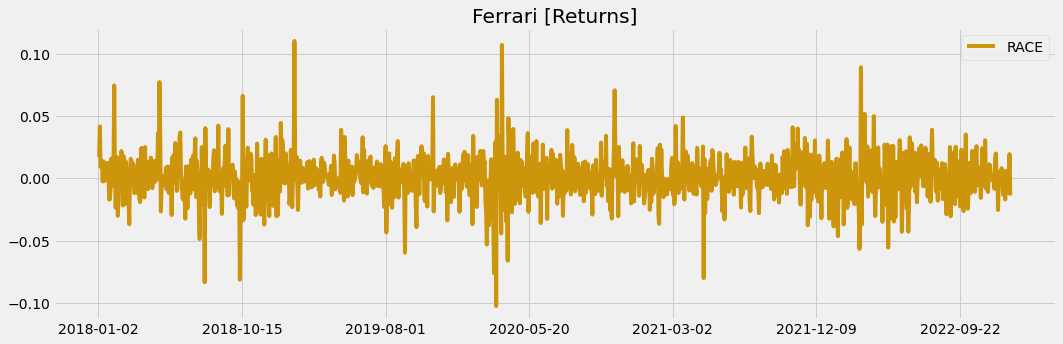

In [10]:
# FERRARI RETURNS
plt.figure(figsize=(16, 5)) 
plt.title("Ferrari [Returns]") 
returns.RACE.plot(color='#CD950C') 
plt.grid(True); 
plt.legend()
plt.savefig("returns.png")

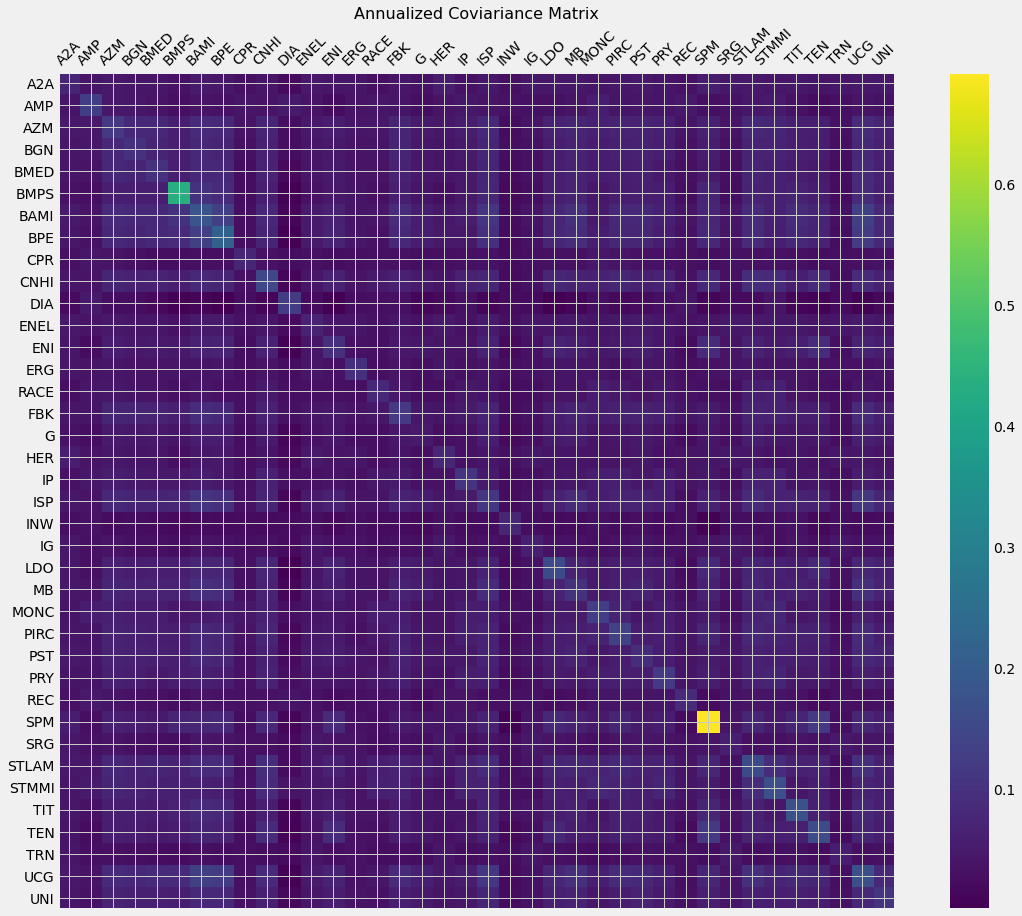

In [11]:
# ANNUALIZED COVARIANCE MATRIX
covMatrix_annual = returns.cov()*252
f = plt.figure(figsize=(19, 15))
plt.matshow(covMatrix_annual, fignum=f.number)
plt.xticks(range(returns.select_dtypes(['number']).shape[1]), returns.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(returns.select_dtypes(['number']).shape[1]), returns.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Annualized Coviariance Matrix', fontsize=16)
plt.savefig("covariance matrix.png")


In [12]:
# PORTFOLIO VARIANCE
portfolioVariance = np.dot(weights.T,np.dot(covMatrix_annual,weights))

# PORTFOLIO VOLATILITY (STANDARD DEVIATION)
portfolioVolatiliy = np.sqrt(portfolioVariance)

# ANNUAL PORTFOLIO RETURN
portfolioSimpleAnnualReturn = np.sum(returns.mean()*weights)*252


In [13]:
# SHOWING THE EXPECTED ANNUAL RETURN, VOLATILITY (RISK) AND VARIANCE OF THE EQUALLY WEIGHTED PORTFOLIO
percentVariance = str(round(portfolioVariance,2)*100)+'%'
percentVolatility = str(round(portfolioVolatiliy,2)*100)+'%'
percentReturn = str(round(portfolioSimpleAnnualReturn,2)*100)+'%'

print('Expected Annual Return: ' + percentReturn)
print('Annual Volatility (Risk): ' + percentVolatility)
print('Annual Variance: ' + percentVariance)


Expected Annual Return: 9.0%
Annual Volatility (Risk): 22.0%
Annual Variance: 5.0%


In [14]:
# NOW LET'S COMPUTE PORTFOLIO OPTIMIZATION

# CALCULATE THE EXPECTED RETURNS AND THE ANNUALIZED SAMPLE COVARIANCE MATRIX OF ASSETS RETURNS
mu = expected_returns.mean_historical_return(dataset)
S = risk_models.sample_cov(dataset)

# NOW WE OPTIMIZE FOR THE MAXIMIMUM SHARPE RATIO AND THE WE GET THE "RAW" WEIGHTS
efficient_frontier = EfficientFrontier(mu,S)
weights = efficient_frontier.max_sharpe()

# NOW WE CLEAN THE "RAW" WEIGHTS BY SETTING ANY WEIGHTS WHOSE ABSOLUTE VALUES 
# ARE BELOW THE CUTOFF (0.0001) TO ZERO, AND ROUNDING THE REST
cleaned_weights = efficient_frontier.clean_weights()
print(cleaned_weights) 
efficient_frontier.portfolio_performance(verbose = True)

OrderedDict([('A2A', 0.0), ('AMP', 0.05759), ('AZM', 0.0), ('BGN', 0.0), ('BMED', 0.0), ('BMPS', 0.0), ('BAMI', 0.0), ('BPE', 0.0), ('CPR', 0.0), ('CNHI', 0.0), ('DIA', 0.04384), ('ENEL', 0.0), ('ENI', 0.0), ('ERG', 0.24439), ('RACE', 0.38237), ('FBK', 0.05521), ('G', 0.0), ('HER', 0.0), ('IP', 0.0), ('ISP', 0.0), ('INW', 0.17706), ('IG', 0.0), ('LDO', 0.0), ('MB', 0.0), ('MONC', 0.0), ('PIRC', 0.0), ('PST', 0.0), ('PRY', 0.0), ('REC', 0.0), ('SPM', 0.0), ('SRG', 0.0), ('STLAM', 0.0), ('STMMI', 0.0), ('TIT', 0.0), ('TEN', 0.0), ('TRN', 0.03954), ('UCG', 0.0), ('UNI', 0.0)])
Expected annual return: 16.8%
Annual volatility: 21.1%
Sharpe Ratio: 0.70


(0.16840597159431953, 0.21066301811015278, 0.7044709267229814)

In [15]:
# EXTRACT THE CLEANED WEIGHTS
list_cleaned_weights = list()
for key,value in cleaned_weights.items():
    if value != 0:
        list_cleaned_weights.append((key,value))

list_cleaned_weights = sorted(list_cleaned_weights, key=lambda x: -x[1])
list_cleaned_weights


[('RACE', 0.38237),
 ('ERG', 0.24439),
 ('INW', 0.17706),
 ('AMP', 0.05759),
 ('FBK', 0.05521),
 ('DIA', 0.04384),
 ('TRN', 0.03954)]

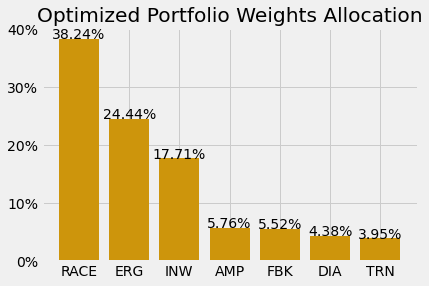

In [16]:
# BARPLOT OF THE OPTIMIZED WEIGHTS ALLOCATION 

keys = [x[0] for x in list_cleaned_weights]
values = [x[1] for x in list_cleaned_weights]

fig, ax = plt.subplots()
ax.bar(keys, values, color='#CD950C')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Optimized Portfolio Weights Allocation')
for i, v in enumerate(values):
    ax.text(i, v, str(round(v*100,2))+'%', ha='center', fontweight='normal')

def percent(x, pos):
    return '{:.0%}'.format(x)
percent_formatter = mtick.FuncFormatter(percent)
ax.yaxis.set_major_formatter(percent_formatter)
plt.savefig(" opt weights.png")
plt.show()


In [17]:
# DISCRETE ALLOCATION OF EACH SHARE PER STOCK WITH A PORTFOLIO OF € 20000
lates_prices = get_latest_prices(dataset)
da = DiscreteAllocation(cleaned_weights,lates_prices,total_portfolio_value=20000)
allocation, leftover = da.lp_portfolio()
print('Discrete Allocation: ', allocation)
print('Funds Remaining: €{:.2f}'.format(leftover))

Discrete Allocation:  {'AMP': 41, 'DIA': 7, 'ERG': 169, 'RACE': 38, 'FBK': 71, 'INW': 376, 'TRN': 115}
Funds Remaining: €9.66


/opt/anaconda3/lib/python3.9/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


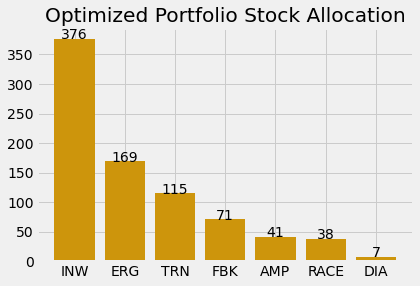

In [19]:
# BARPLOT OF THE STOCK DISCRETE ALLOCATION
da.lp_portfolio()
disc_alloc_list = list()
for key,value in allocation.items():
    disc_alloc_list.append((key,value))

disc_alloc_list = sorted(disc_alloc_list, key=lambda x: -x[1])

keys = [x[0] for x in disc_alloc_list]
values = [x[1] for x in disc_alloc_list]

fig, ax = plt.subplots()
ax.bar(keys, values, color='#CD950C')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title("Optimized Portfolio Stock Allocation")
for i, v in enumerate(values):
    ax.text(i, v, str(v), ha='center', fontweight='normal')
plt.savefig("opt stock.png")
plt.show()

